In [1]:
import warnings
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, reading CSV file
import seaborn as sns # statistical data visualization
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt # data visualization
import missingno as msno
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
from IPython.display import Audio, display
import librosa # audio analysis library for sound signal processing.
import librosa.display # visualization functions for sound signal.
import soundfile as sf
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, SimpleRNN, TimeDistributed, Embedding, concatenate
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from pathlib import Path

Load Files from Directory

In [2]:
# Set the path to the RAVDESS dataset directory
working_directory = os.getcwd()
dataset_path = working_directory + '/VIVAE/full_set'
# dataset_path = working_directory + '/ravdess/audio_speech_actors_01-24'
print(dataset_path)

/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANALYTICS/Projects/Assignment/Dissertation/VIVAE/full_set


Feature Extraction

In [3]:
# Define the list of emotions
emotions = ["excitement", "anger", "fear", "pain", "pleasure", "surprise"]
intensities = ["low", "moderate", "strong", "peak"]

# Initialize empty lists to store features and labels
features = []
path = []
labels = []
emotional_intensity = []

# Iterate through the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        if not filename.endswith(".wav"):
            continue
        # Extract the emotion, intensity, and other information from the filename
        try:
            speaker, emotion, intensity, item_id = filename.split("_")[:4]
        except ValueError:
            print(f"Invalid file name format: {filename}")
            continue

        # Replace "achievement" with "excitement" in the emotion label
        emotion = "excitement" if emotion == "achievement" else emotion

        # Load the audio file using Librosa
        file_path = os.path.join(root, filename)
        audio, sr = librosa.load(file_path, sr=None)

        # Extract features (e.g., MFCCs) from the audio
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

        # Append the features and labels to the respective lists
        features.append(mfcc.T)  # Transpose the mfcc array
        path.append(file_path)
        labels.append(emotion)
        emotional_intensity.append(intensity)

# Convert the lists to NumPy arrays
features = np.array(features, dtype=object)
path = np.array(path, dtype=object)
labels = np.array(labels)
emotional_intensity = np.array(emotional_intensity)

# Print the shape of the features and labels arrays
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (1085,)
Labels shape: (1085,)


In [4]:
# Create a DataFrame with emotion labels and features
df_emotions = pd.DataFrame({'Emotions': labels, 'Intensity': emotional_intensity, 'Features': features, 'Files': path})
df_emotions

,Emotions,Intensity,Features,Files
0,pain,peak,"[[-569.94543, 46.569016, 17.799828, 5.51118, 2...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1,fear,peak,"[[-500.18906, 128.53162, -8.754978, -34.86943,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
2,fear,peak,"[[-421.14496, 139.59421, -43.698925, -59.27306...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
3,surprise,low,"[[-693.25464, 122.10651, -19.881027, -6.270700...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
4,surprise,strong,"[[-583.41833, 109.90478, 62.786293, 15.019434,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
...,...,...,...,...
1080,pain,low,"[[-759.26416, 102.60452, 28.44986, 16.478876, ...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1081,excitement,low,"[[-648.6186, 30.728882, 27.772568, 23.343136, ...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1082,surprise,moderate,"[[-500.56894, 122.53467, -23.421618, -17.87593...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1083,excitement,low,"[[-736.86395, 60.957848, 36.95472, 22.24996, 2...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [5]:
df_emotions.head()

,Emotions,Intensity,Features,Files
0,pain,peak,"[[-569.94543, 46.569016, 17.799828, 5.51118, 2...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1,fear,peak,"[[-500.18906, 128.53162, -8.754978, -34.86943,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
2,fear,peak,"[[-421.14496, 139.59421, -43.698925, -59.27306...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
3,surprise,low,"[[-693.25464, 122.10651, -19.881027, -6.270700...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
4,surprise,strong,"[[-583.41833, 109.90478, 62.786293, 15.019434,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [6]:
df_emotions.tail()

,Emotions,Intensity,Features,Files
1080,pain,low,"[[-759.26416, 102.60452, 28.44986, 16.478876, ...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1081,excitement,low,"[[-648.6186, 30.728882, 27.772568, 23.343136, ...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1082,surprise,moderate,"[[-500.56894, 122.53467, -23.421618, -17.87593...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1083,excitement,low,"[[-736.86395, 60.957848, 36.95472, 22.24996, 2...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1084,anger,peak,"[[-549.6946, 42.053143, 25.977633, 16.64059, 1...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [7]:
df_emotions.dtypes

Emotions     object
Intensity    object
Features     object
Files        object
dtype: object

In [8]:
# Checking for missing data using the cleaning tehniques
emotions_null = df_emotions.isnull()
#emotions_null = df_emotions.isnull().any()
emotions_null.sum()

Emotions     0
Intensity    0
Features     0
Files        0
dtype: int64

<Axes: >

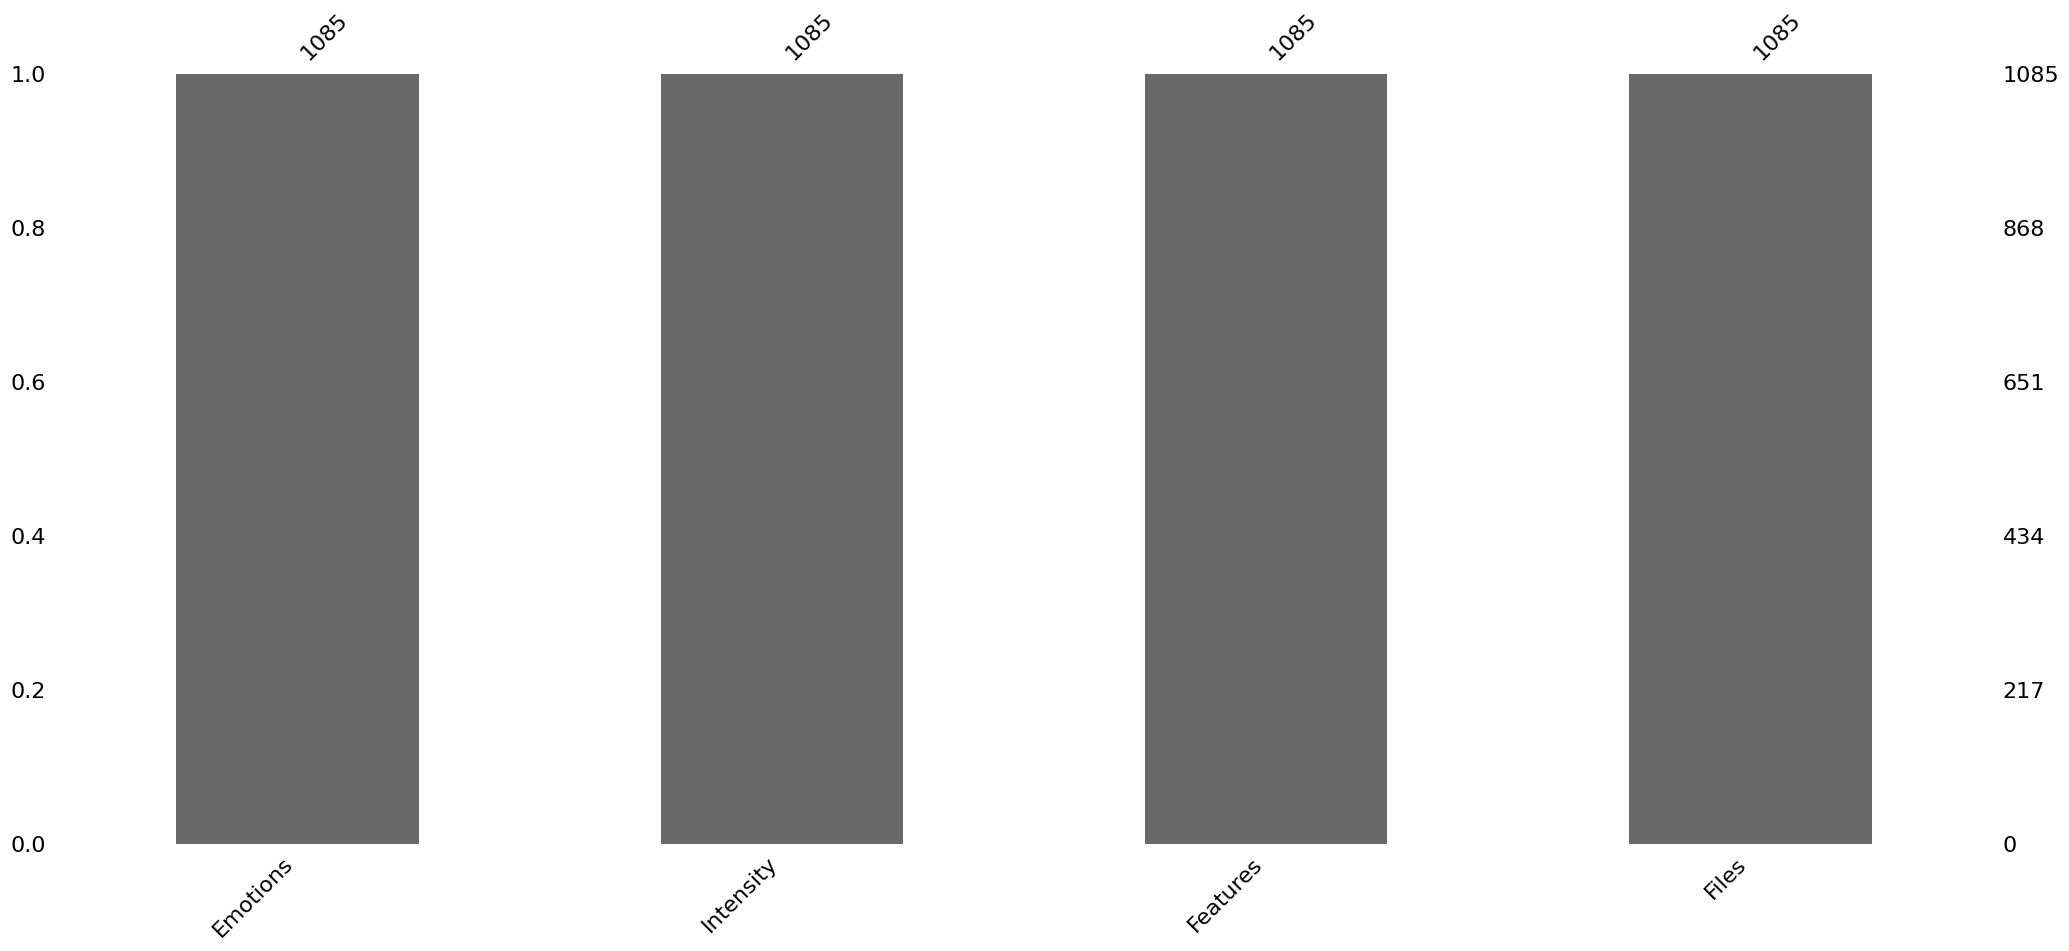

In [9]:
# Graphical representation of missing value
msno.bar(df_emotions)

In [10]:
# Datasets information
df_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Emotions   1085 non-null   object
 1   Intensity  1085 non-null   object
 2   Features   1085 non-null   object
 3   Files      1085 non-null   object
dtypes: object(4)
memory usage: 34.0+ KB


In [11]:
# Frequency distribution of categorical variables for Emotions
print("Emotions Attributes \n")
col_emotions = ['Emotions', 'Intensity']
for i in col_emotions:
    print(df_emotions[i].value_counts(),"\n")

Emotions Attributes 

Emotions
pleasure      202
surprise      187
pain          185
fear          176
anger         174
excitement    161
Name: count, dtype: int64 

Intensity
strong      282
peak        272
moderate    269
low         262
Name: count, dtype: int64 



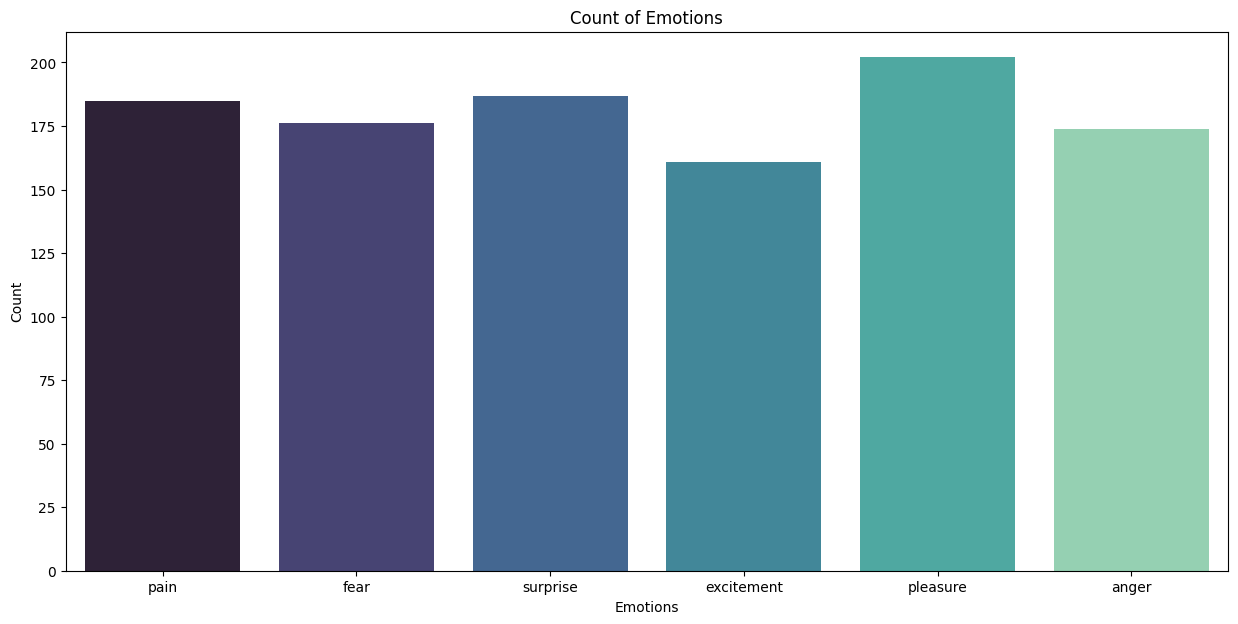

In [12]:
# Suppress FutureWarning about is_categorical_dtype
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the figures of the plot
fig, ax = plt.subplots(figsize=(15, 7))

# Create a bar plot using Seaborn
sns.countplot(data=df_emotions, x='Emotions', palette='mako', ax=ax)

# Set the plot title and axis labels
plt.title('Count of Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')

# Show the plot
plt.show()

# Reset warnings filter
warnings.filterwarnings("default", category=FutureWarning)

<Figure size 640x480 with 0 Axes>

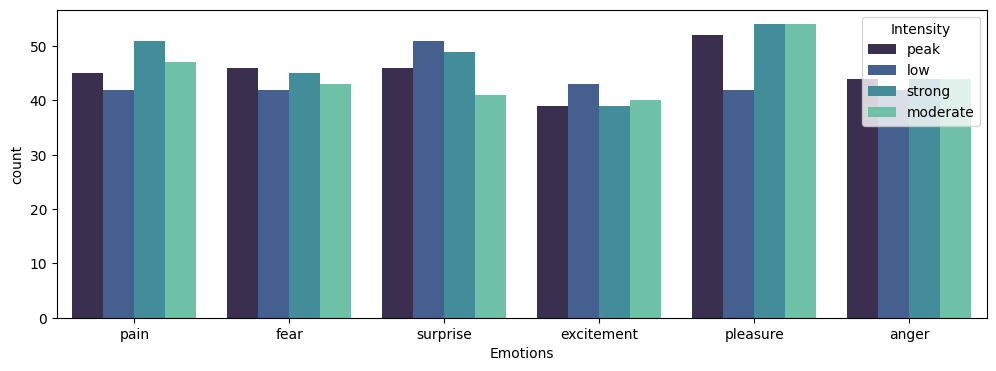

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

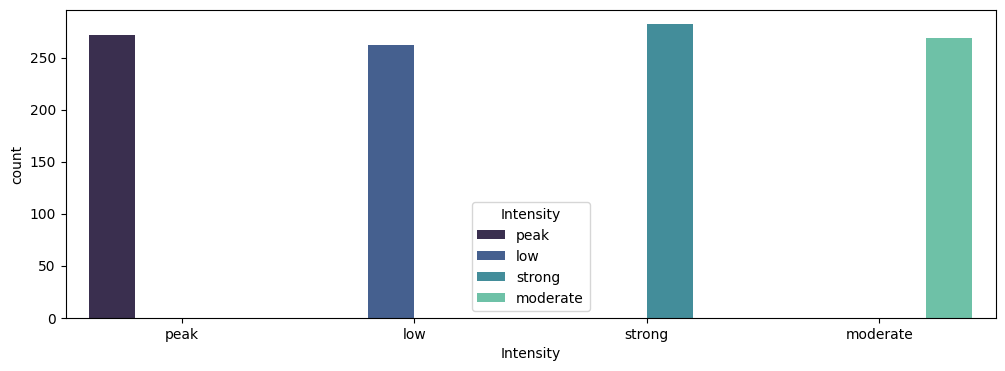

In [13]:
def freq_dist(data) :
    # This test a block of code for errors used to catch and handle exceptions
    try:
        df_std = data.select_dtypes(exclude=['int64'])
        df_excluded = df_std.iloc[:, :-2]
        for i, col in enumerate(df_excluded.columns):
            warnings.filterwarnings("ignore")
            plt.figure(i)
            # it creates a new figure for the plot
            plt.figure()
            fig, ax = plt.subplots(figsize=(12,4))
            sns.countplot(x=col, hue='Intensity', data=df_excluded, ax=ax, palette='mako')
        return plt.show()
    # IOError is an exception type error that occurs when the file that we passed in as argument
    except ValueError:
            print("Invalid literal for int() with base 10 ")
            print("Kindly insert an integer value")
    except:
        print("Some other exception happened.")
freq_dist(df_emotions)

In [14]:
# Declaring a functiopn create_wave_spect function to return plots and spectogram of each emotions
def create_wave_spect(emotion, cmap='magma'):
    path = np.array(df_emotions['Files'][df_emotions['Emotions'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    
    # Plot of waveform
    plt.figure(figsize=(15, 4))
    plt.title('Waveplot for {} emotion'.format(emotion.capitalize()), size=15)
    # librosa.display.waveshow(data, sr=sampling_rate)
    plt.plot(data, color='b')
    plt.show()
    
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot of spectogram
    plt.figure(figsize=(15, 4))
    plt.title('Spectrogram for {} emotion'.format(emotion.capitalize()), size=15)
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz', cmap=cmap)
    plt.colorbar()
    plt.show()
    
    display(Audio(path))

Plots of Excitement


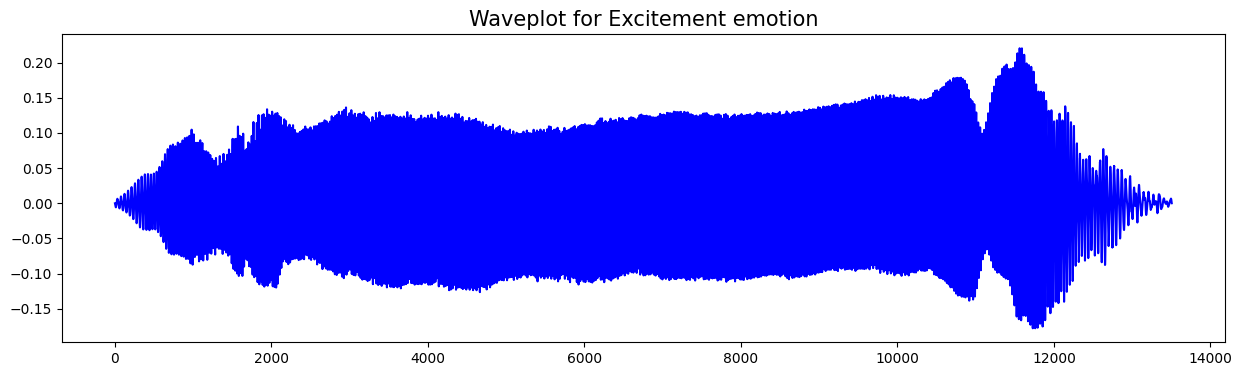

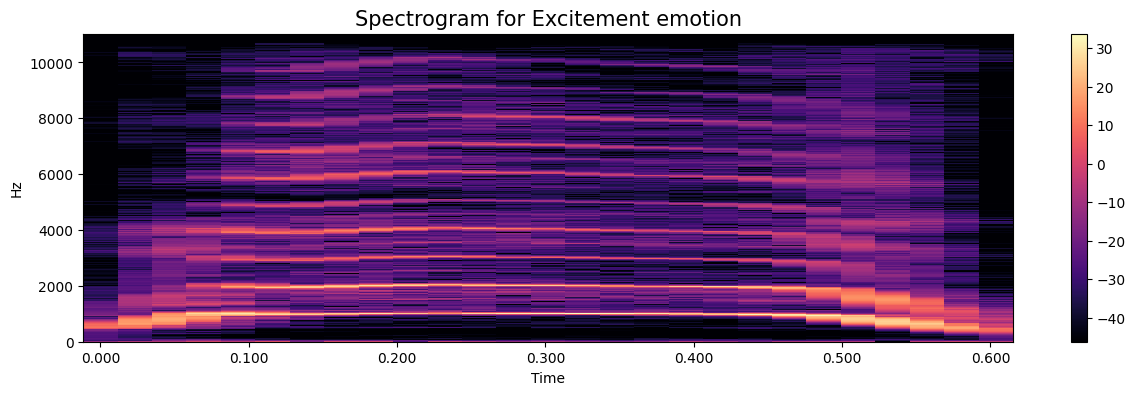

Plots of Anger


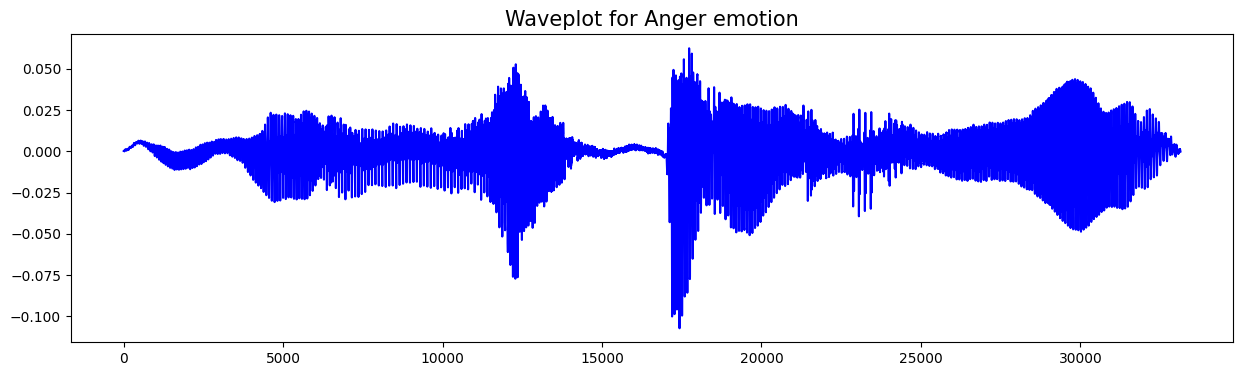

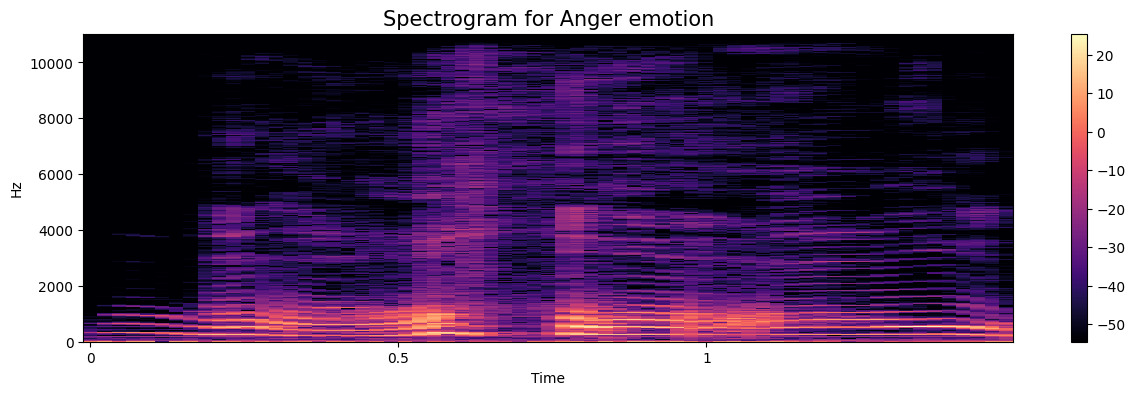

Plots of Fear


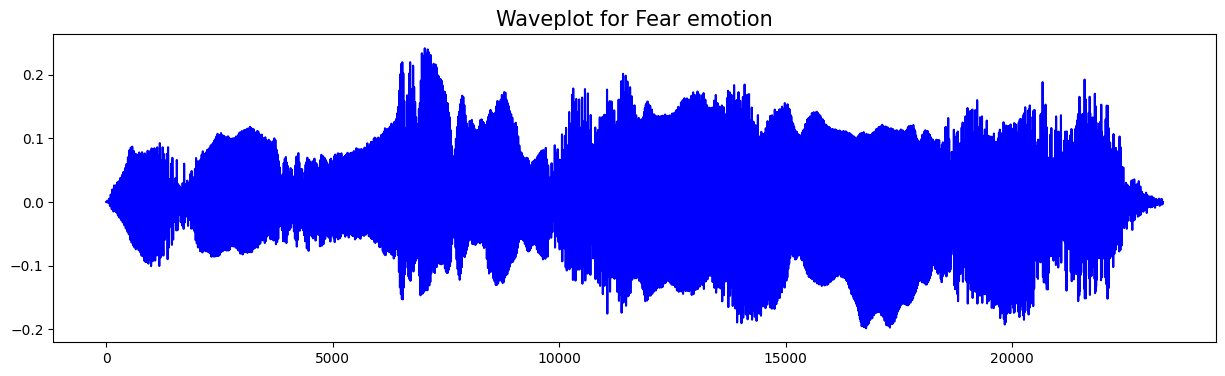

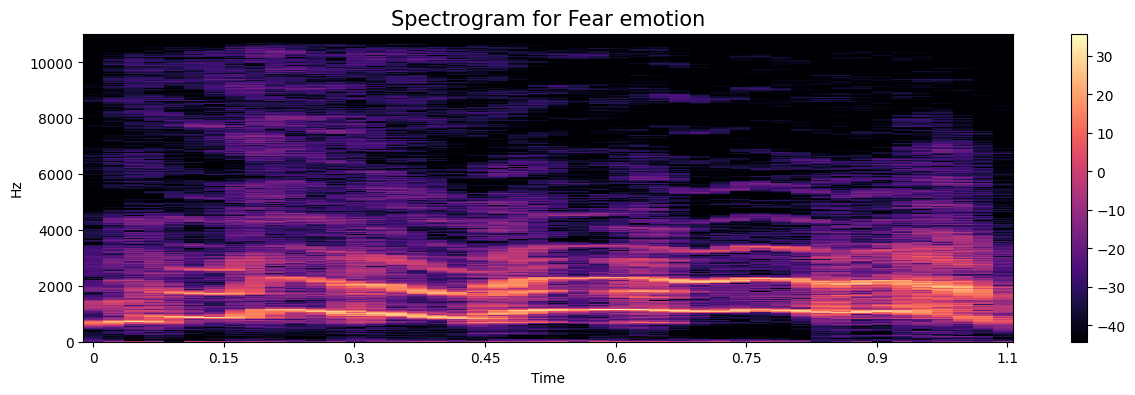

Plots of Pain


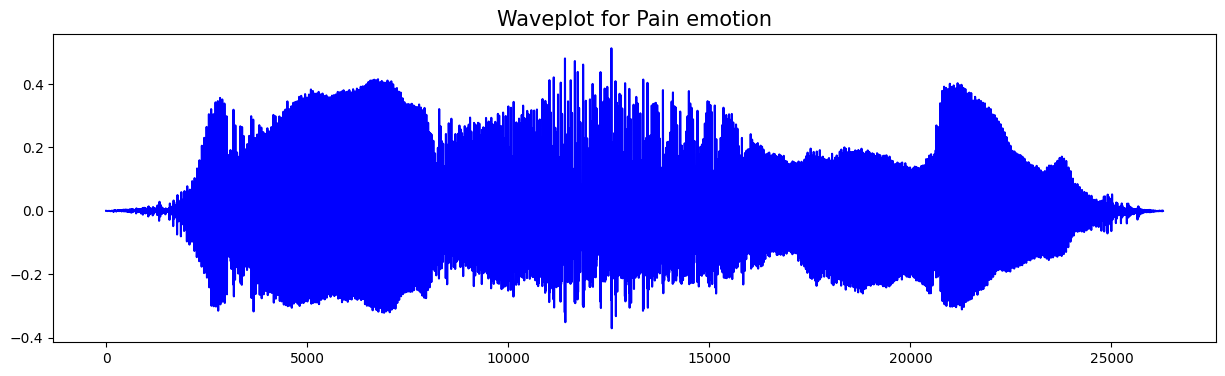

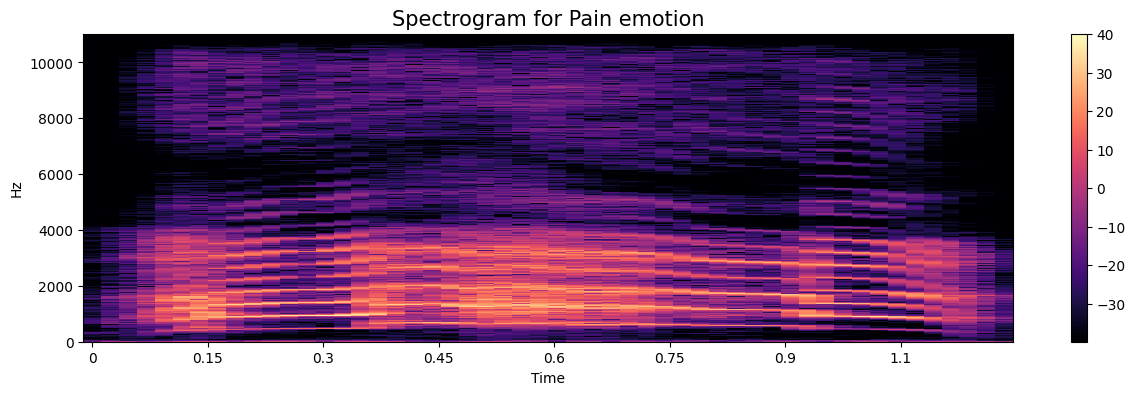

Plots of Pleasure


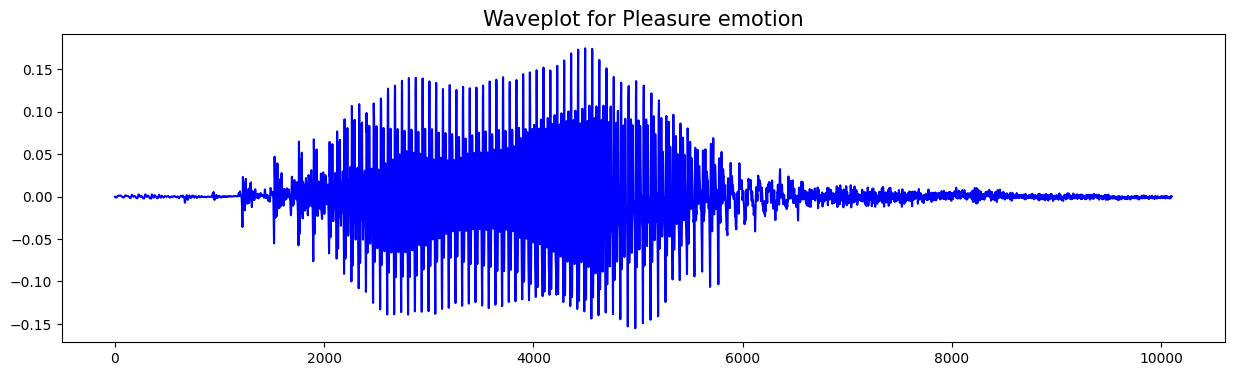

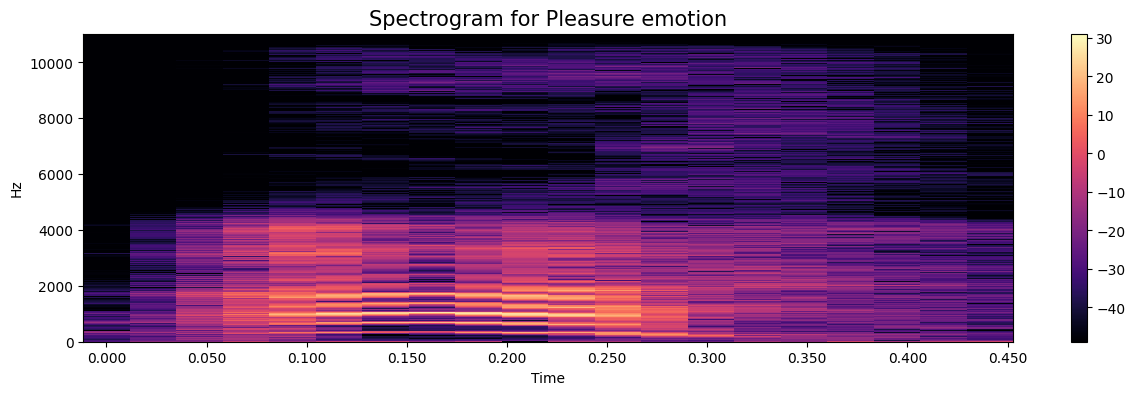

Plots of Surprise


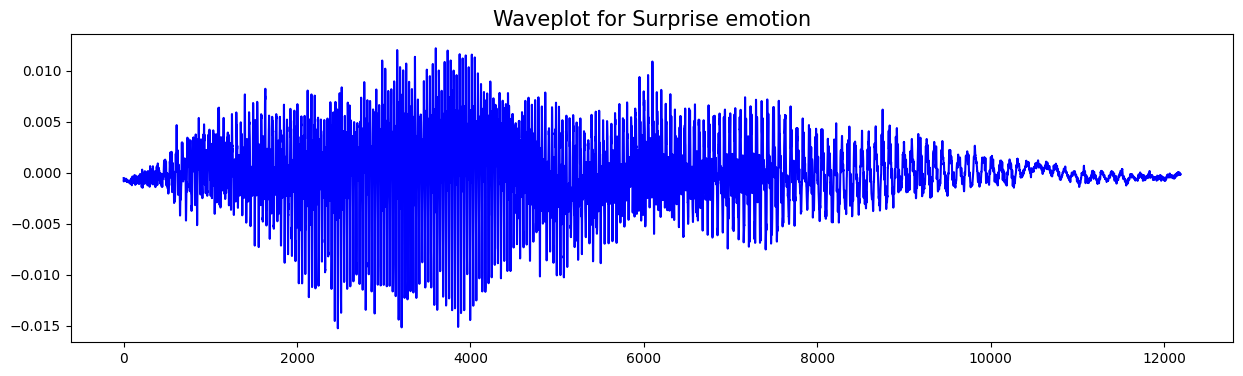

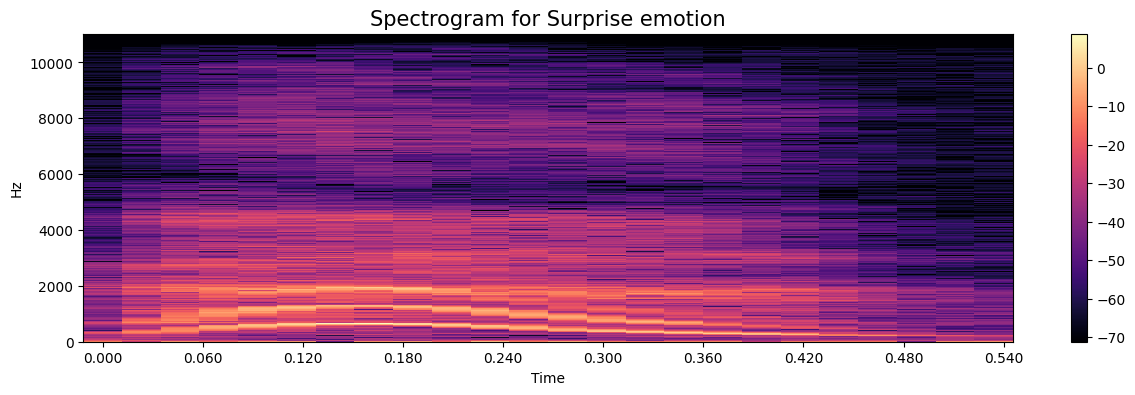

In [15]:
# List of emotions
emotions = ["excitement", "anger", "fear", "pain", "pleasure", "surprise"]

# Loop through emotions and create/display plots
for emotion in emotions:
    print('Plots of', emotion.capitalize())
    create_wave_spect(emotion, cmap='magma')

Feature Engineering

In [14]:
# Load and preprocess your dataset from df_emotions (replace with your data loading code)
def load_and_preprocess_data():
    
    mfcc_features = df_emotions['Features'].tolist()
    emotions = df_emotions['Emotions'].tolist()

    return mfcc_features, emotions

Support Vector Machine (SVM)

In [15]:
# Load and preprocess the dataset
X_mfcc_features, y = load_and_preprocess_data()

# Check the shapes of MFCC features
mfcc_shapes = [mfcc.shape for mfcc in X_mfcc_features]

# Verify if all MFCC feature shapes are the same
if all(shape == mfcc_shapes[0] for shape in mfcc_shapes):
    print("MFCC shapes are consistent:", mfcc_shapes[0])
else:
    print("MFCC shapes are not consistent:", mfcc_shapes)

# Pad MFCC sequences to have the same length (use the maximum sequence length)
max_length = max([len(mfcc) for mfcc in X_mfcc_features])
X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# Reshape the features to 2D (number of samples, number of features)
features_reshaped = X_mfcc_features_padded.reshape(X_mfcc_features_padded.shape[0], -1)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_reshaped, y, test_size=0.2, random_state=42
)

MFCC shapes are not consistent: [(103, 13), (92, 13), (79, 13), (48, 13), (108, 13), (53, 13), (82, 13), (40, 13), (170, 13), (50, 13), (78, 13), (63, 13), (82, 13), (71, 13), (60, 13), (55, 13), (60, 13), (130, 13), (38, 13), (88, 13), (64, 13), (122, 13), (45, 13), (39, 13), (94, 13), (40, 13), (67, 13), (64, 13), (70, 13), (92, 13), (52, 13), (125, 13), (57, 13), (43, 13), (48, 13), (69, 13), (42, 13), (82, 13), (92, 13), (73, 13), (67, 13), (95, 13), (172, 13), (93, 13), (41, 13), (52, 13), (69, 13), (53, 13), (94, 13), (164, 13), (91, 13), (51, 13), (87, 13), (92, 13), (63, 13), (99, 13), (97, 13), (75, 13), (84, 13), (76, 13), (132, 13), (43, 13), (56, 13), (56, 13), (54, 13), (36, 13), (93, 13), (47, 13), (75, 13), (41, 13), (47, 13), (118, 13), (69, 13), (76, 13), (97, 13), (131, 13), (53, 13), (71, 13), (47, 13), (73, 13), (157, 13), (86, 13), (58, 13), (141, 13), (85, 13), (82, 13), (63, 13), (80, 13), (45, 13), (130, 13), (139, 13), (67, 13), (77, 13), (119, 13), (72, 13), (

In [20]:
X_train.shape, X_test.shape

((868, 2249), (217, 2249))

In [21]:
# Create a machine learning pipeline with feature scaling and an SVM classifier
model_svm = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features to have mean=0 and variance=1
    ('pca', PCA(n_components=50)),  # Principal Component Analysis (PCA) for dimensionality reduction
    ('svm', SVC(kernel='linear', C=1.0))  # Support Vector Machine with a linear kernel
])

# Fit the model
model_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy for SVM :', round(accuracy,3) * 100 ,'%')

# Generate a classification report and confusion matrix
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

confusion_svm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion_svm)

Test Accuracy for SVM : 41.9 %
Classification Report:
               precision    recall  f1-score   support

       anger       0.46      0.53      0.49        36
  excitement       0.33      0.39      0.36        31
        fear       0.29      0.29      0.29        42
        pain       0.44      0.37      0.40        41
    pleasure       0.37      0.57      0.45        23
    surprise       0.67      0.45      0.54        44

    accuracy                           0.42       217
   macro avg       0.43      0.43      0.42       217
weighted avg       0.44      0.42      0.42       217

Confusion Matrix:
 [[19  4  2  3  7  1]
 [ 4 12  7  5  1  2]
 [ 7  8 12  4  9  2]
 [ 3  6 10 15  3  4]
 [ 3  3  1  2 13  1]
 [ 5  3  9  5  2 20]]


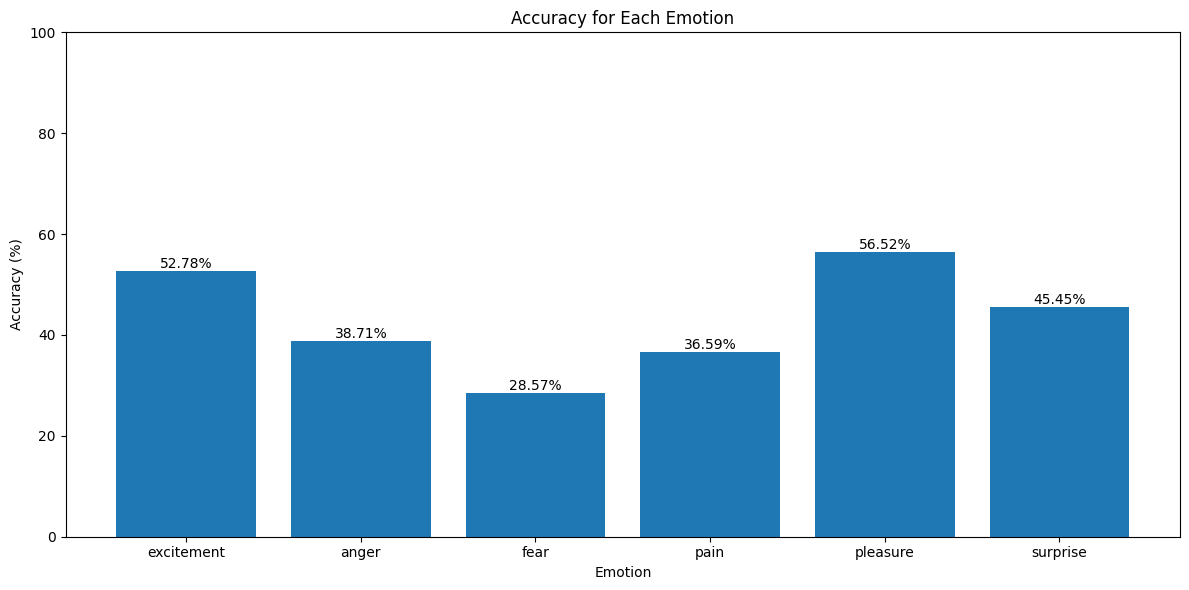

In [22]:
# Calculate accuracy for each emotion SVM
accuracies = []

# Define emotion labels
emotion_labels_svm = ["excitement", "anger", "fear", "pain", "pleasure", "surprise"]

for i in range(len(emotion_labels_svm)):
    correct_predictions = confusion_svm[i, i]
    total_predictions = sum(confusion_svm[i, :])  # Sum of the row for class i
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(emotion_labels_svm, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
plt.title('Accuracy for Each Emotion')
plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# Display the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# Show the plot
plt.tight_layout()
plt.show()

Convolutional Neural Networks (CNNs)

In [23]:
# Load and preprocess the dataset
X_mfcc_features, y_labels = load_and_preprocess_data()

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Pad MFCC sequences to have the same length (use the maximum sequence length)
max_length = max([len(mfcc) for mfcc in X_mfcc_features])
X_mfcc_features_padded = pad_sequences(X_mfcc_features, maxlen=max_length, padding='post', dtype='float32')

# Convert X_mfcc_features_padded to a NumPy array
X_mfcc_features_padded = np.array(X_mfcc_features_padded)

# Define the number of classes (emotions)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_features_padded, y_encoded, test_size=0.2, random_state=42)

In [24]:
X_train.shape, X_test.shape

((868, 173, 13), (217, 173, 13))

In [25]:
# Define the CNN model
model_cnn = Sequential([
    Input(shape=X_mfcc_features_padded.shape[1:]),  # Input shape based on your MFCC feature dimension
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with classes based on your emotion categories
])

# Compile the model
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
              metrics=['accuracy'])

# Train the model
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f'Test Accuracy for CNNs :', round(test_acc,3) * 100 ,'%')

# Make predictions
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode encoded labels back to original emotions
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate a classification report and confusion matrix
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    report_cnn = classification_report(y_test_original, y_pred_original)
print('Classification Report:\n', report_cnn)

confusion_cnn = confusion_matrix(y_test_original, y_pred_original)
print('Confusion Matrix:\n', confusion_cnn)

Epoch 1/10
22/22 [==============================] - 1s 19ms/step - loss: 10.7649 - accuracy: 0.1844 - val_loss: 1.9246 - val_accuracy: 0.1724
Epoch 2/10
22/22 [==============================] - 0s 6ms/step - loss: 1.8413 - accuracy: 0.2104 - val_loss: 1.7831 - val_accuracy: 0.2011
Epoch 3/10
22/22 [==============================] - 0s 5ms/step - loss: 1.7771 - accuracy: 0.2406 - val_loss: 1.7768 - val_accuracy: 0.2184
Epoch 4/10
22/22 [==============================] - 0s 6ms/step - loss: 1.7651 - accuracy: 0.2435 - val_loss: 1.7594 - val_accuracy: 0.2529
Epoch 5/10
22/22 [==============================] - 0s 6ms/step - loss: 1.7544 - accuracy: 0.2450 - val_loss: 1.7343 - val_accuracy: 0.2586
Epoch 6/10
22/22 [==============================] - 0s 6ms/step - loss: 1.7203 - accuracy: 0.2478 - val_loss: 1.6932 - val_accuracy: 0.2989
Epoch 7/10
22/22 [==============================] - 0s 6ms/step - loss: 1.7158 - accuracy: 0.2651 - val_loss: 1.6857 - val_accuracy: 0.2644
Epoch 8/10
22/22 [

In [26]:
np.max(y_pred, axis=1)

array([0.18306944, 0.18306944, 0.1909811 , 0.20020206, 0.25235367,
       0.20329978, 0.21297643, 0.42120802, 0.18306944, 0.24982929,
       0.19781683, 0.20163931, 0.24261035, 0.42326808, 0.18392065,
       0.5563885 , 0.22269872, 0.18306944, 0.8038922 , 0.2110543 ,
       0.25311592, 0.22363627, 0.22508606, 0.19986463, 0.34147376,
       0.2529616 , 0.21774629, 0.26960844, 0.3420441 , 0.2528346 ,
       0.6142253 , 0.1842735 , 0.5205864 , 0.19124506, 0.18306944,
       0.3344627 , 0.24803285, 0.19383825, 0.22640745, 0.18386021,
       0.303806  , 0.2243328 , 0.48310912, 0.21651338, 0.36746612,
       0.24150537, 0.18306944, 0.18306944, 0.21593964, 0.2332848 ,
       0.22080305, 0.25697523, 0.31811416, 0.34637916, 0.33898342,
       0.6767305 , 0.27800116, 0.22268112, 0.20333478, 0.18306944,
       0.1854293 , 0.18306944, 0.183623  , 0.18823235, 0.20486975,
       0.33535522, 0.24088034, 0.20636913, 0.39299175, 0.24268606,
       0.20563091, 0.23815162, 0.18976611, 0.22432813, 0.19758

In [27]:
# Define a confidence threshold (e.g., 0.7)
confidence_threshold = 0.7
max_probabilities = np.max(y_pred, axis=1)
low_confidence_indices = np.where(max_probabilities < confidence_threshold)[0]
print(low_confidence_indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216]


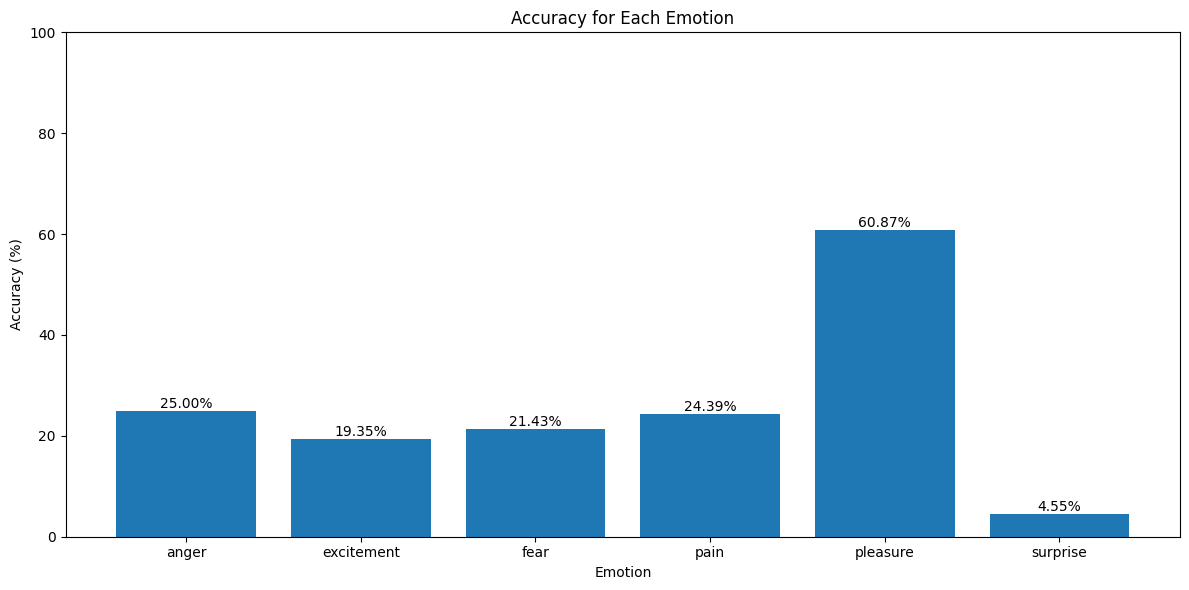

In [28]:
# Calculate accuracy for each emotion
accuracies = []
for i in range(num_classes):
    correct_predictions = confusion_cnn[i, i]
    total_predictions = sum(confusion_cnn[i, :])  # Sum of the row for class i
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)

# Define emotion labels (from label_encoder.classes_)
emotion_labels = label_encoder.classes_

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(emotion_labels, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
plt.title('Accuracy for Each Emotion')
plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# Display the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
# # Save your trained model
# documents_path = Path.home() / 'Documents'
# subdirectory = 'flask/SpeechEmotionApp/model'
# target_directory = documents_path / subdirectory

# # Create the target directory if it doesn't exist
# target_directory.mkdir(parents=True, exist_ok=True)

# # Save the model within the target directory
# model_cnn.save(target_directory / 'cnns_model')
# model_cnn.save_weights(target_directory / 'cnns_model/model_weights.h5')

Recurrent Neural Networks (RNNs)

In [30]:
# Define the RNN model
# model_rnn = Sequential([
#     SimpleRNN(128, return_sequences=True, input_shape=(max_length, X_mfcc_features_padded.shape[2])),
#     SimpleRNN(64),
#     Dense(num_classes, activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model_rnn.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model
# model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model_rnn.evaluate(X_test, y_test)
# print(f'Test Accuracy for RNNs :', round(test_acc,3) * 100 ,'%')

# # Make predictions
# y_pred = model_rnn.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(y_test)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)

#     report_rnn = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report_rnn)

# confusion_rnn = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion_rnn)

In [31]:
# Calculate accuracy for each emotion
# accuracies = []
# for i in range(num_classes):
#     correct_predictions = confusion_rnn[i, i]
#     total_predictions = sum(confusion_rnn[i, :])  # Sum of the row for class i
#     accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
#     accuracies.append(accuracy)

# # Define emotion labels (from label_encoder.classes_)
# emotion_labels = label_encoder.classes_

# # Plot the bar chart
# plt.figure(figsize=(12, 6))
# plt.bar(emotion_labels, [accuracy * 100 for accuracy in accuracies])  # Convert accuracies to percentages
# plt.xlabel('Emotion')
# plt.ylabel('Accuracy (%)')  # Change the ylabel to 'Accuracy (%)'
# plt.title('Accuracy for Each Emotion')
# plt.ylim(0, 100)  # Set the y-axis limit to the range [0, 100]

# # Display the accuracy values on top of the bars
# for i, accuracy in enumerate(accuracies):
#     plt.text(i, accuracy * 100, f'{accuracy * 100:.2f}%', ha='center', va='bottom')  # Convert accuracy to percentage

# # Show the plot
# plt.tight_layout()
# plt.show()

CNN-RNN Hybrid model

In [32]:
# Reshape MFCC features for CNN input
# X_train_cnn = X_train[..., np.newaxis]  # Add a channe0l dimension
# X_test_cnn = X_test[..., np.newaxis]

# # Define the CNN-RNN Hybrid model
# model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', input_shape=X_train_cnn[0].shape),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     TimeDistributed(Flatten()),  # Apply Flatten to each time step
#     SimpleRNN(64, return_sequences=True),  # RNN layer after CNN
#     SimpleRNN(64),
#     Dense(64, activation='relu'),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
# print(f'Test Accuracy for Hybrid :', round(test_acc,3) * 100 ,'%')

# # Make predictions
# y_pred = model.predict(X_test_cnn)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(y_test)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)

#     report = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report)

# confusion = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion)

In [33]:
# # Define the neural network model
# model_lstm = Sequential([
#     Input(shape=X_mfcc_features_padded.shape[1:]),  # Define input shape based on your feature dimension
#     LSTM(128, activation='relu', return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, activation='relu'),
#     Dropout(0.5),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes based on your emotion categories
# ])

# # Compile the model_lstm
# model_lstm.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical cross-entropy for integer-encoded labels
#               metrics=['accuracy'])

# # Train the model_lstm
# model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# # Evaluate the model_lstm
# test_loss, test_acc = model_lstm.evaluate(X_test, y_test)
# print(f'Test accuracy: {test_acc}')

# # Make predictions
# y_pred = model_lstm.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode one-hot encoded labels back to original emotions
# y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# # Generate a classification report and confusion matrix
# report = classification_report(y_test_original, y_pred_original)
# print('Classification Report:\n', report)

# confusion = confusion_matrix(y_test_original, y_pred_original)
# print('Confusion Matrix:\n', confusion)

In [34]:
df_emotions

,Emotions,Intensity,Features,Files
0,pain,peak,"[[-569.94543, 46.569016, 17.799828, 5.51118, 2...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1,fear,peak,"[[-500.18906, 128.53162, -8.754978, -34.86943,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
2,fear,peak,"[[-421.14496, 139.59421, -43.698925, -59.27306...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
3,surprise,low,"[[-693.25464, 122.10651, -19.881027, -6.270700...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
4,surprise,strong,"[[-583.41833, 109.90478, 62.786293, 15.019434,...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
...,...,...,...,...
1080,pain,low,"[[-759.26416, 102.60452, 28.44986, 16.478876, ...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1081,excitement,low,"[[-648.6186, 30.728882, 27.772568, 23.343136, ...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1082,surprise,moderate,"[[-500.56894, 122.53467, -23.421618, -17.87593...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...
1083,excitement,low,"[[-736.86395, 60.957848, 36.95472, 22.24996, 2...",/Users/oyelamiabdulhafeez/Desktop/BIG DATA ANA...


In [35]:
def load_balancing_data():
    
    mfcc_features = df_emotions.iloc[:,-2:-1]
    emotions = df_emotions.iloc[:, 2:3]

    return mfcc_features, emotions
X, y = load_balancing_data()

In [36]:
# Plot pie chart
fig = plt.figure(figsize=(15, 8))
y.value_counts().plot.pie(autopct='%.2f%%')
plt.show()

# Display value counts
print(y.value_counts())

TypeError: unhashable type: 'numpy.ndarray'

<Figure size 1500x800 with 0 Axes>

In [ ]:
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy="not majority")
x_smote, y_smote = smote.fit_resample(X,y)
fig = plt.figure(figsize=(15,8))
ax = y_smote.value_counts().plot.pie(autopct='%.2f%%')
ax.set_title("Synthetic Minority Over-sampling Technique")
y_smote.value_counts()